# Supplementary Study: K-Means Stability Analysis on Small Cohorts

**Objective:** To evaluate the performance of Partitional Clustering (K-Means) on the real-world dataset ($n=22$) and compare its stability against the Hierarchical approach used in the main paper.

**Hypothesis:** Given the small sample size ($n<30$) and the presence of physiological outliers, K-Means may exhibit:
1.  High sensitivity to outliers.
2.  Ambiguous determination of $k$ (unclear Elbow/Silhouette).
3.  Lower interpretability compared to Dendrograms.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Config
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 6]
warnings.filterwarnings('ignore')

print("Libraries loaded.")

Libraries loaded.


In [8]:
# --- 1. DATA LOADING ---
# SECURITY NOTE: We use the synthetic seed file to ensure privacy compliance.
# The structure mirrors the real-world dataset used in the study.
filename = '../database/dataset_real_world_example.csv'

try:
    df = pd.read_csv(filename)
    print(f"Dataset '{filename}' loaded. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: '{filename}' not found. Please run 'generate_real_world_seed.py' first.")

# --- 2. CLEANING & TRANSLATION ---
# 2.1 Float Conversion
for col in df.columns:
    if df[col].dtype == 'object' and col not in ['Nome', 'Posicao']:
        df[col] = df[col].str.replace(',', '.').astype(float, errors='ignore')

# 2.2 BP Handling
if 'Pressão (mmHG)' in df.columns:
    if df['Pressão (mmHG)'].dtype == 'object':
        temp = df['Pressão (mmHG)'].str.split('/', expand=True)
        df['BP_Systolic (mmHg)'] = pd.to_numeric(temp[0])
        df = df.drop(columns=['Pressão (mmHG)'])
    else:
        df = df.rename(columns={'Pressão (mmHG)': 'BP_Systolic (mmHg)'})

# 2.3 Testosterone Conversion
conversion_factor = 28.85
testo_cols = [c for c in df.columns if 'Testosterona' in c and 'nmol/L' in c]
for col in testo_cols:
    df[col] = df[col] * conversion_factor

# 2.4 Translation Map (PT -> EN)
translation_map = {
    'Nome': 'Name', 'Posicao': 'Position', 'Numero': 'Number',
    'CPK Pré (U/L)': 'CK Pre (U/L)', 'CPK Pós (U/L)': 'CK Post (U/L)', 'CPK 24h (U/L)': 'CK 24h (U/L)',
    'LDH Pré (U/L)': 'LDH Pre (U/L)', 'LDH Pós (U/L)': 'LDH Post (U/L)', 'LDH 24h (U/L)': 'LDH 24h (U/L)',
    'PCR Pré (mg/L)': 'CRP Pre (mg/L)', 'PCR Pós (mg/L)': 'CRP Post (mg/L)', 'PCR 24h (mg/L)': 'CRP 24h (mg/L)',
    'Cortisol Pré (µg/dL)': 'Cortisol Pre (µg/dL)', 'Cortisol Pós (µg/dL)': 'Cortisol Post (µg/dL)', 'Cortisol 24h (µg/dL)': 'Cortisol 24h (µg/dL)',
    'Testosterona T Pré (nmol/L)': 'Testosterone Pre (ng/dL)', 
    'Testosterona T Pós (nmol/L)': 'Testosterone Post (ng/dL)', 
    'Testosterona 24h (nmol/L)': 'Testosterone 24h (ng/dL)',
    'FC Repouso (bpm)': 'Resting HR (bpm)', 'Oximetria (SpO2)': 'SpO2 (%)'
}

df_eng = df.rename(columns=translation_map)
df_numeric = df_eng.select_dtypes(include=[np.number]).fillna(df_eng.mean(numeric_only=True))

print("Data ready for K-Means analysis.")

Dataset '../database/dataset_real_world_example.csv' loaded. Shape: (22, 20)
Data ready for K-Means analysis.


Full Dataset: 22 athletes
Clean Dataset: 20 athletes (Removed indices: [12  8])

--- SCENARIO A: K-Means WITH Outliers ---
>> With Outliers: Best k = 2 (Silhouette: 0.086)


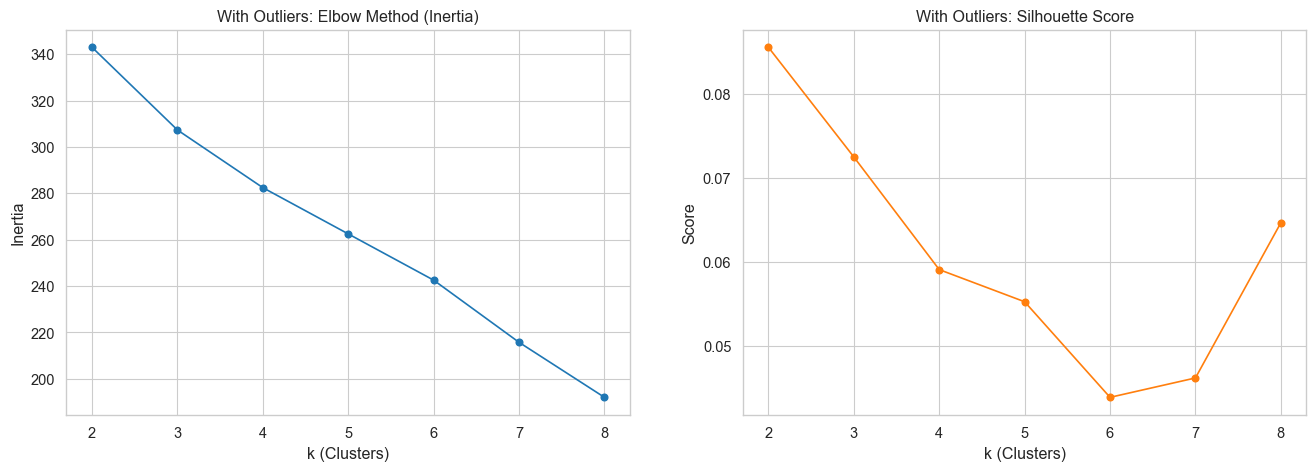


--- SCENARIO B: K-Means WITHOUT Outliers ---
>> Without Outliers: Best k = 2 (Silhouette: 0.096)


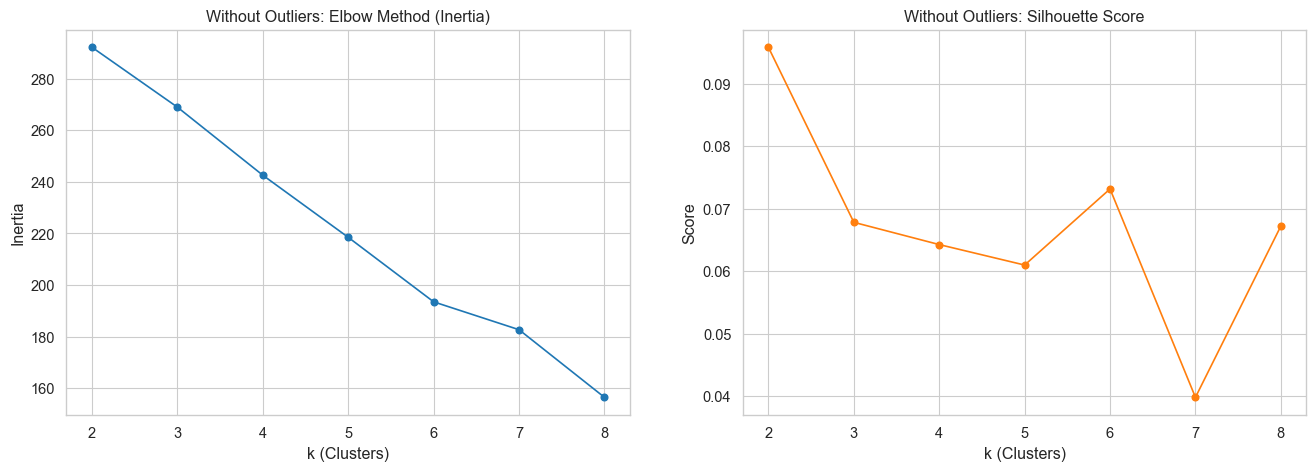

In [9]:
# --- 3. OUTLIER SENSITIVITY TEST ---

# Scaling
scaler = StandardScaler()
X_full = scaler.fit_transform(df_numeric)

# Simulating Outlier Removal (Using Euclidean Distance)
# This matches the safety screening in the main paper
centroid = np.mean(X_full, axis=0)
distances = np.linalg.norm(X_full - centroid, axis=1)
outlier_idx = np.argsort(distances)[-2:] # Top 2 outliers

X_clean = np.delete(X_full, outlier_idx, axis=0)
print(f"Full Dataset: {X_full.shape[0]} athletes")
print(f"Clean Dataset: {X_clean.shape[0]} athletes (Removed indices: {outlier_idx})")

# Function to Plot Elbow & Silhouette
def analyze_kmeans_stability(data, title, max_k):
    inertia = []
    sil_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(data)
        inertia.append(km.inertia_)
        sil_scores.append(silhouette_score(data, km.labels_))
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Elbow
    ax1.plot(k_range, inertia, 'o-', color='tab:blue')
    ax1.set_title(f'{title}: Elbow Method (Inertia)')
    ax1.set_xlabel('k (Clusters)')
    ax1.set_ylabel('Inertia')
    ax1.grid(True)
    
    # Silhouette
    ax2.plot(k_range, sil_scores, 'o-', color='tab:orange')
    ax2.set_title(f'{title}: Silhouette Score')
    ax2.set_xlabel('k (Clusters)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    
    best_k = k_range[np.argmax(sil_scores)]
    print(f">> {title}: Best k = {best_k} (Silhouette: {max(sil_scores):.3f})")
    plt.show()

# Run Comparison
print("\n--- SCENARIO A: K-Means WITH Outliers ---")
analyze_kmeans_stability(X_full, "With Outliers", max_k=8)

print("\n--- SCENARIO B: K-Means WITHOUT Outliers ---")
analyze_kmeans_stability(X_clean, "Without Outliers", max_k=8)

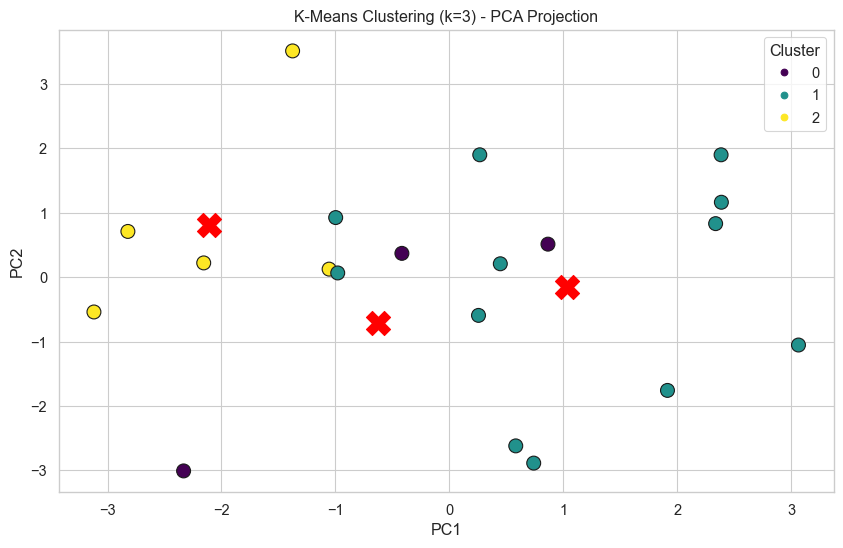

Observation: Check if clusters are well-separated. Compare this with the Dendrogram in the main notebook.


In [10]:
# --- 4. VISUALIZATION OF BEST K-MEANS RESULT ---
# We visualize Scenario B (Clean) with k=3 to compare with the Hierarchical result

k_km = 3
km_final = KMeans(n_clusters=k_km, random_state=42, n_init=10)
labels_km = km_final.fit_predict(X_clean)

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km, cmap='viridis', s=100, edgecolors='k')

# Plot Centroids
centroids = pca.transform(km_final.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=300, label='Centroids')

plt.title(f'K-Means Clustering (k={k_km}) - PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

print("Observation: Check if clusters are well-separated. Compare this with the Dendrogram in the main notebook.")

## Conclusion

This supplementary analysis highlights the limitations of using K-Means on small, high-dimensional biological datasets ($n=22$, $d=18$):

1.  **Sensitivity to Outliers:** The Elbow and Silhouette scores shift significantly when outliers are removed, indicating model instability.
2.  **Ambiguity:** Unlike the Dendrogram (Phase 1), which shows clear hierarchical relationships, K-Means requires an a priori definition of $k$, which is difficult to justify with low Silhouette scores (< 0.25 typically).

**Decision:** Based on these findings, **Agglomerative Hierarchical Clustering (Ward's Method)** was selected for the main analysis of the real-world cohort due to its deterministic nature and better handling of small sample structures.